In [10]:
from pathlib import Path
import pandas as pd
from typing import Dict
from irregular.org import Org
from irregular.contract import Contract
from irregular.config import Config


In [11]:
# data's directory path
path_data_dir = Path.cwd().parent / 'data'
# irregular constract files's directory path
path_irregular_contract_dir = path_data_dir / 'irregular_contracts'
# get irregular contract files handle
irr_filenames = [f for f in sorted(
    path_irregular_contract_dir.glob('20*.xlsx'))]


In [12]:
path_file = irr_filenames[-1]
path_config = path_irregular_contract_dir / 'config.old.xlsx'
path_file, path_config


(PosixPath('/Users/levin/workspace/git-repositories/anaconda/study-pandas-tutorials/Work/data/irregular_contracts/20220428.xlsx'),
 PosixPath('/Users/levin/workspace/git-repositories/anaconda/study-pandas-tutorials/Work/data/irregular_contracts/config.old.xlsx'))

In [13]:
# read config
config = Config(path_config)
# read data from excel sheet
dfs: Dict[str, pd.DataFrame] = {}
xls = pd.ExcelFile(path_file)
for sheet_name, key in config.excel_sheet_dict().items():
    dfs[key] = pd.read_excel(xls, sheet_name)
# read org
df_org: pd.DataFrame = dfs['org'] \
    .rename(columns=config.org_code_dict())
# read project
df_project: pd.DataFrame = dfs['projects'] \
    .rename(columns=config.project_code_dict())
# read irregular contract
df_irr_contract: pd.DataFrame = dfs['irr'] \
    .rename(columns=config.contract_code_dict())
# TODO: should be deleted
# duplicated by contract NO.
df_irr_contract = df_irr_contract.drop_duplicates(
    subset='contract_no'
)
# TODO: ---END
# apply whitelist
df_whitelist = pd.read_excel(path_irregular_contract_dir / 'whitelist.xlsx')
df_irr_contract = df_irr_contract[~df_irr_contract['contract_no']
                                  .isin(df_whitelist['contract_no'])]
# extract incremental irregular contract
df_increase: pd.DataFrame = None
if len(irr_filenames) > 1:
    df_lp = pd.read_excel(irr_filenames[-2], sheet_name='02不规范合同分子') \
        .rename(columns=config.contract_code_dict())
    df_increase = df_irr_contract[~df_irr_contract['contract_no']
                                  .isin(df_lp['contract_no'])]
else:
    df_increase = df_irr_contract
# read contracts. also call 'denominator'
df_contracts = dfs['contracts'] \
    .rename(columns=config.contract_code_dict())


/var/folders/p7/6ch6lkc521b7mw6l51zmx4v80000gn/T/ipykernel_36050/1125705859.py:7: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  dfs[key] = pd.read_excel(xls, sheet_name)


In [14]:
# make org
org = Org(df_org, df_project)
# make irregular contract
contract_irr = Contract(
    df_irr_contract,
    config
)
# make contract. Also call 'denominator'
contracts = Contract(
    df_contracts,
    config
)
# make incremental contract
contract_increase = Contract(
    df_increase,
    config
)


In [15]:
grouped_list = ['branch_name', 'dept_name', 'category']
# category for irregular contract
df_category = df_irr_contract \
    .drop_duplicates(subset=['category'])[['category']]
# cross department with category
df_dept_cross = pd.merge(
    org.department(),
    df_category,
    how='cross'
)[grouped_list].set_index(grouped_list)


In [16]:
# group by department
df_irr_grouped = contract_irr.counted_with_org(org) \
    .groupby(grouped_list)[['count']] \
    .sum() \
    .rename(columns={
        'count': 'irr_count'
    })
df_contracts_grouped = contracts.counted_with_org(org) \
    .groupby(grouped_list)[['count']] \
    .sum()
df_counted = pd.concat([
    df_irr_grouped,
    df_contracts_grouped],
    axis=1)
df_counted = pd.concat([
    df_dept_cross,
    df_counted],
    axis=1)
df_counted['ratio'] = round(
    df_counted['irr_count'] /
    df_counted['count'],
    4)
df_counted['irr_count_by_branch'] = df_counted \
    .groupby(level=(0, 2))['irr_count'] \
    .transform('sum')
df_counted['count_by_branch'] = df_counted \
    .groupby(level=(0, 2))['count'] \
    .transform('sum')
df_counted['average_ratio_by_branch'] = round(
    df_counted['irr_count_by_branch'] /
    df_counted['count_by_branch'],
    4
)
df_counted['irr_count_by_division'] = df_counted \
    .groupby(level=(2))['irr_count'] \
    .transform('sum')
df_counted['count_by_division'] = df_counted \
    .groupby(level=(2))['count'] \
    .transform('sum')
df_counted['average_ratio_by_division'] = round(
    df_counted['irr_count_by_division'] /
    df_counted['count_by_division'],
    4
)
df_counted = df_counted.fillna(0).convert_dtypes()
df_counted.index.names = config.analysis_row_dict().values()
df_counted_report = df_counted.rename(columns=config.analysis_column_dict())


In [17]:
# group by branch
df_reported_branch = df_counted_report.droplevel(1, axis=0)
df_reported_branch = df_reported_branch[
    ~df_reported_branch.index.duplicated()] \
    .iloc[:, 3:] \
    .sort_index(level=0) \
    .reset_index()


In [18]:
def analysis_by_branch(
    df_counted: pd.DataFrame
) -> pd.DataFrame:
    df = df_counted.droplevel(1, axis=0)
    df = df[~df.index.duplicated()].iloc[:, [5]] \
        .unstack() \
        .droplevel(0, axis=1) 

    return df


In [45]:
out_dir = Path.cwd().parent / 'output' / 'irregular_contracts'
if not out_dir.exists():
    out_dir.mkdir()

out_filename = f'{path_file.stem}-租赁平台-合同规范性检查（下发）.xlsx'

out_path = out_dir / out_filename

with pd.ExcelWriter(out_path) as writer:
    contract_irr.report(org.project()).to_excel(writer, sheet_name='不合规范合同清单')
    contract_increase.report(org.project()).to_excel(
        writer, sheet_name='不合规范合同清单(增量)')
    df_counted_report.to_excel(writer, sheet_name='统计结果')

out_analysis_path = out_dir / f'{path_file.stem}-analysis.xlsx'

with pd.ExcelWriter(out_analysis_path) as writer:
    analysis_by_branch(df_counted_report).to_excel(writer, sheet_name='Sheet1')
    df_reported_branch.to_excel(writer, sheet_name='Sheet2')

org.project().to_excel(
    out_dir / 'project_with_org.xlsx'
)


In [46]:
df_analysis_by_branch = analysis_by_branch(df_counted_report)
df_analysis_by_branch['综合评分'] = df_analysis_by_branch.mean(axis=1)
df_analysis_by_branch = df_analysis_by_branch.sort_values(['综合评分'])
df_analysis_by_branch

不合规情况,倒签,应算未算,应结未结,综合评分
分公司,,,,
番禺科技园,0.0,0.0377,0.0755,0.037733
文化产业公司,0.0,0.0625,0.0625,0.041667
产园-青岛公司,0.0,0.0,0.3333,0.111100
南油平方,0.4,0.0,0.0,0.133333
园区运营中心,0.0294,0.3077,0.2051,0.180733
产园-重庆公司,0.1277,0.0667,0.5312,0.241867
产园-武汉公司,0.1333,0.25,0.4167,0.266667
产园-南京公司,0.3483,0.0448,0.5735,0.322200
产园-杭州公司,0.378,0.0306,0.6545,0.354367


In [47]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

<AxesSubplot:xlabel='分公司'>

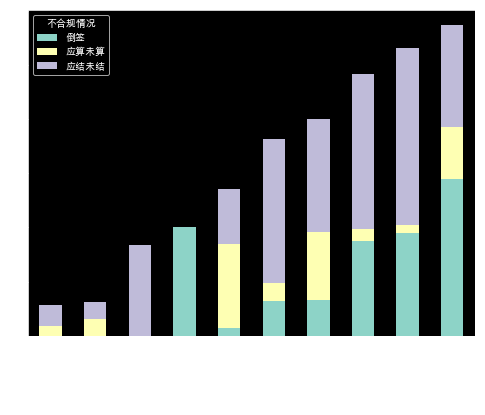

In [57]:
plt_analysis = df_analysis_by_branch.iloc[:, :3].plot.bar(figsize=(8, 6), stacked=True, rot=45)
plt_analysis.get_figure().savefig(out_dir / 'a.png', dpi=800, bbox_inches='tight')
plt_analysis